In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mlm_training.model import Model, make_model_param
from mlm_training.pianoroll import Pianoroll

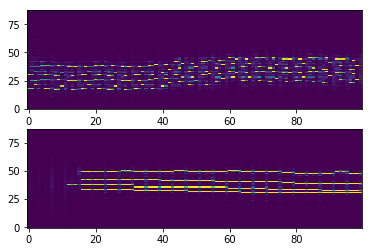

In [106]:
fig, [ax1,ax2] = plt.subplots(2,1)
ax1.imshow(preds_1[2],aspect='auto',origin='lower')
ax2.imshow(preds_1[0],aspect='auto',origin='lower')
plt.show()

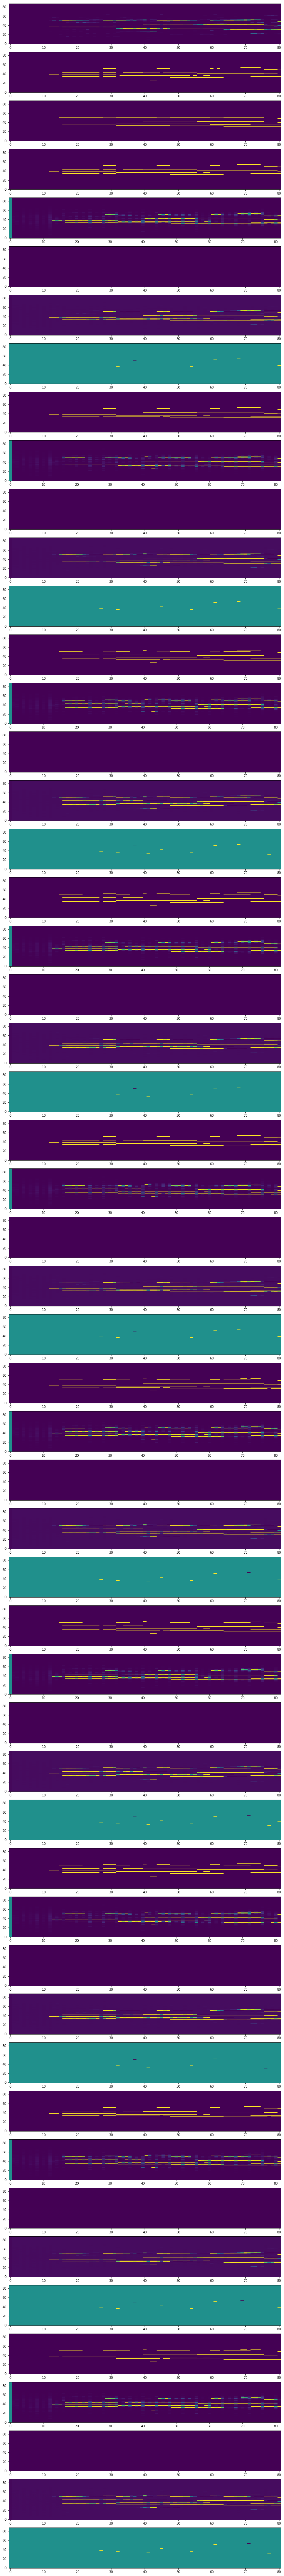

In [32]:
# For viewing beam at a given frame (after running decode.py with --out outputs)

import dataMaps
import pickle
import matplotlib.pyplot as plt

data = dataMaps.DataMaps()
data.make_from_file("data/outputs/test/MAPS_MUS-chpn-p4_ENSTDkAm.mid", "quant", section=[0, 30])

frame = 80
num = 10

frame = min(data.input.shape[1] - 1, frame)

if num > 0:
    with open("results/tmp/data_" + str(frame) + ".pkl", "rb") as file:
        out = pickle.load(file)

acoustic = data.input[:, :frame + 1]
midi = data.target[:, :frame + 1]

fig, ax = plt.subplots(3 + num * 5, 1, figsize=(15,15 + num * 13))
ax[1].imshow((acoustic>0.5).astype(int), aspect='auto', origin='lower')
ax[0].imshow(acoustic, aspect='auto', origin='lower')
ax[2].imshow(midi, aspect='auto', origin='lower')
for i in range(num):
    ax[3 + 5*i].imshow(out[i][0], aspect='auto', origin='lower')
    ax[4 + 5*i].imshow(out[i][1], aspect='auto', origin='lower')
    ax[5 + 5*i].imshow(out[i][2], aspect='auto', origin='lower')
    ax[6 + 5*i].imshow(out[i][3], aspect='auto', origin='lower')
    ax[7 + 5* i].imshow(out[i][0] - (acoustic>0.5).astype(int), aspect='auto', origin='lower')
plt.show()

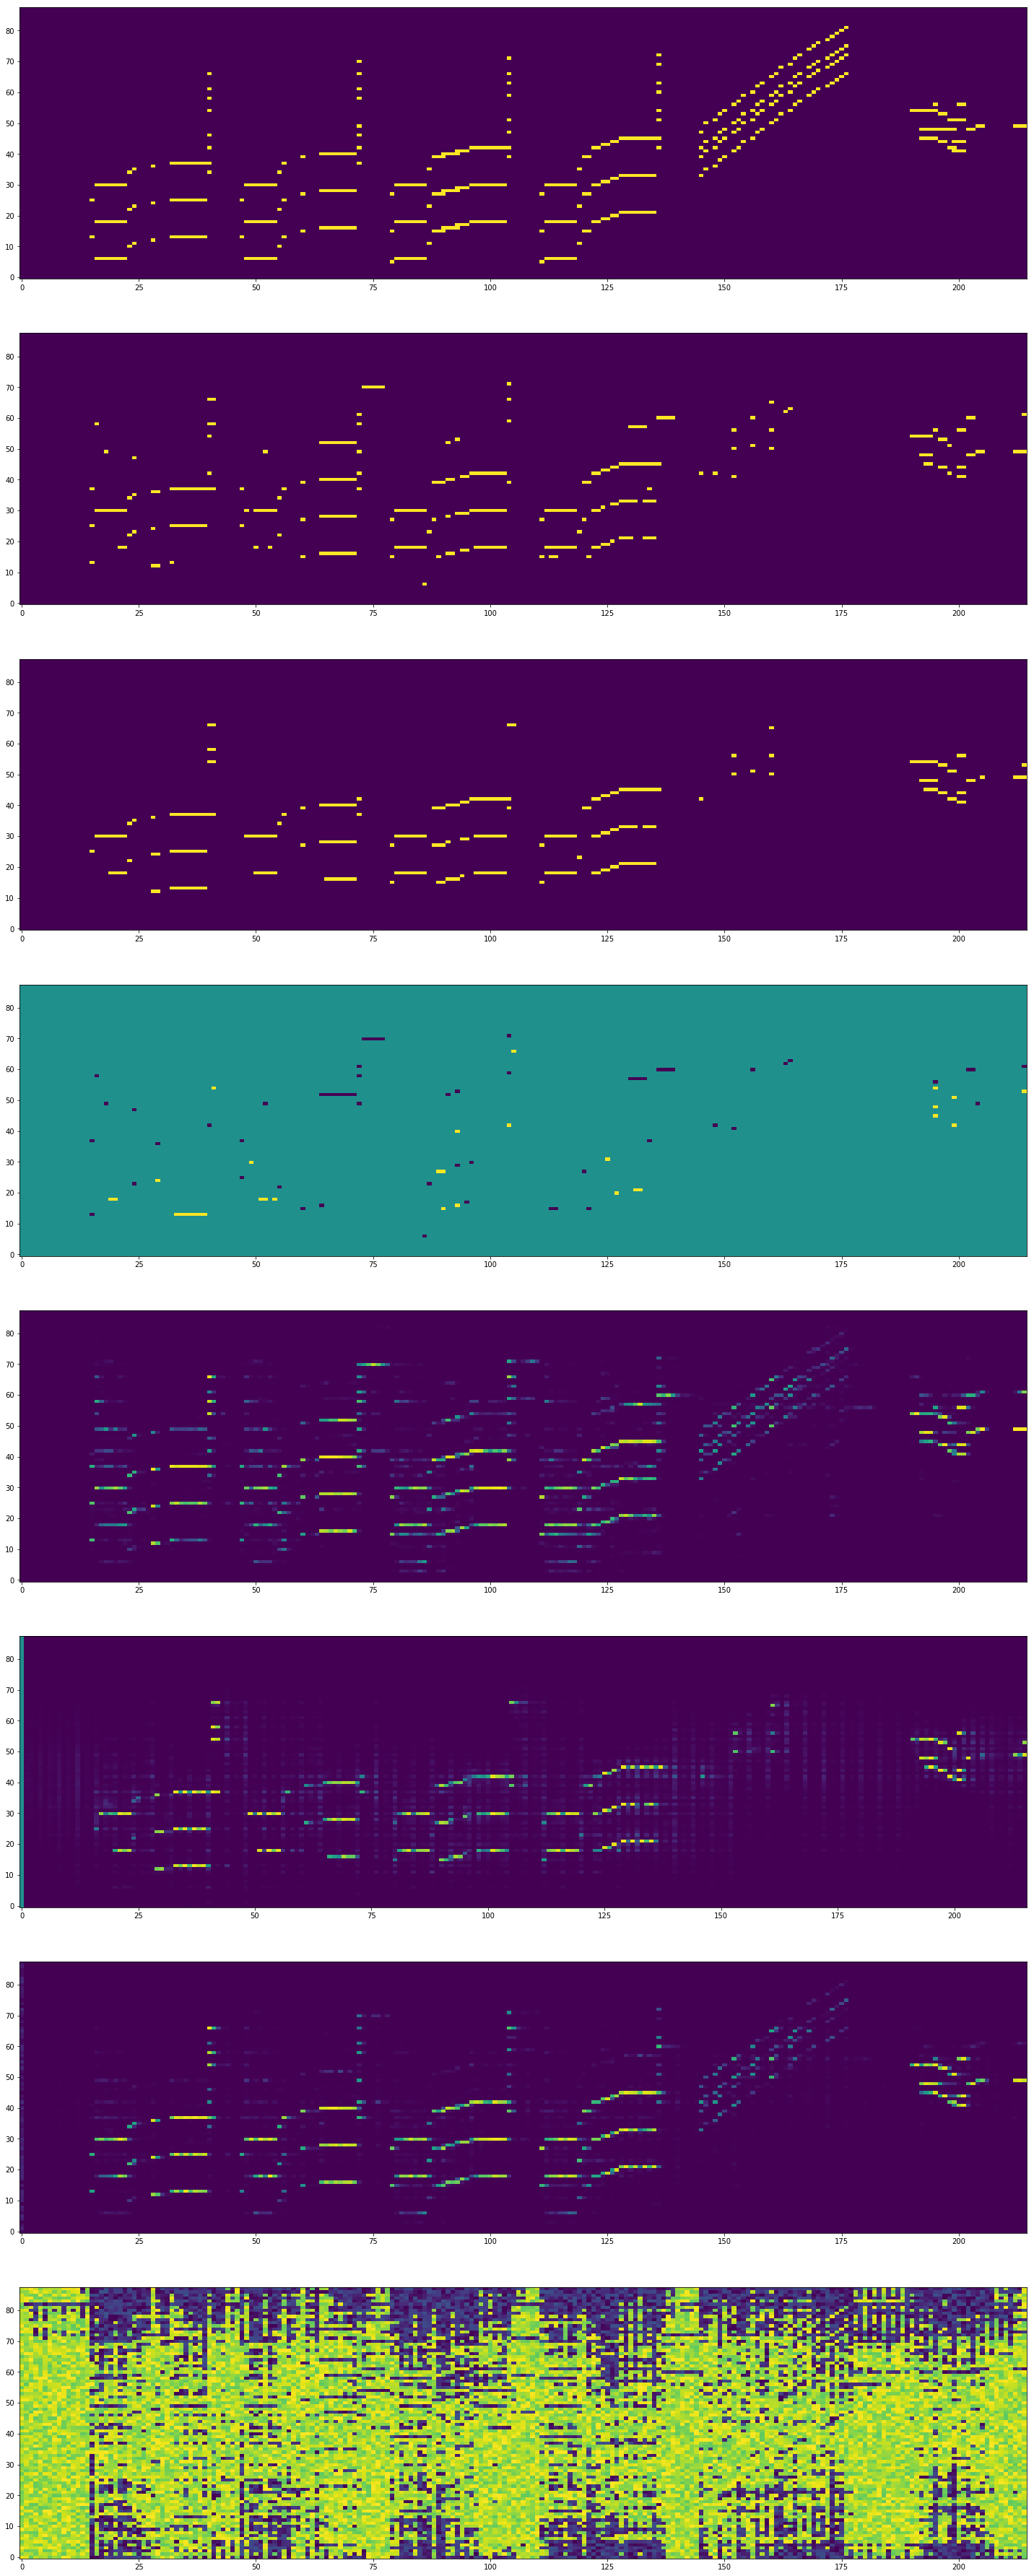

In [11]:
# For viewing results of final output

import dataMaps
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

norm = Normalize(vmin=0, vmax=1)

step = "quant"
folder = "results/save/save-" + step + "-gtweight-0.25"
basename = "MAPS_MUS-liz_rhap09_ENSTDkAm"

pr = np.load(os.path.join(folder, basename + "_pr.npy"))
if not folder.endswith("hmm"):
    priors = np.load(os.path.join(folder, basename + "_priors.npy"))
    weights = np.load(os.path.join(folder, basename + "_weights.npy"))
    combined_priors = np.load(os.path.join(folder, basename + "_combined_priors.npy"))

data = dataMaps.DataMaps()
data.make_from_file("data/outputs/test/" + basename + ".mid", step, section=[0, 30])

acoustic = data.input
midi = data.target

fig, ax = plt.subplots(5 if folder.endswith("hmm") else 8, 1, figsize=(25,40 if folder.endswith("hmm") else 65))
ax[0].imshow(midi, aspect='auto', origin='lower')
ax[1].imshow((acoustic>0.5).astype(int), aspect='auto', origin='lower')
ax[2].imshow(pr, aspect='auto', origin='lower')
ax[3].imshow(pr - (acoustic>0.5).astype(int), aspect='auto', origin='lower')
ax[4].imshow(acoustic, aspect='auto', origin='lower')
if not folder.endswith("hmm"):
    ax[5].imshow(priors, aspect='auto', origin='lower', norm=norm)
    ax[6].imshow(combined_priors, aspect='auto', origin='lower', norm=norm)
    ax[7].imshow(weights, aspect='auto', origin='lower', norm=norm)
plt.show()

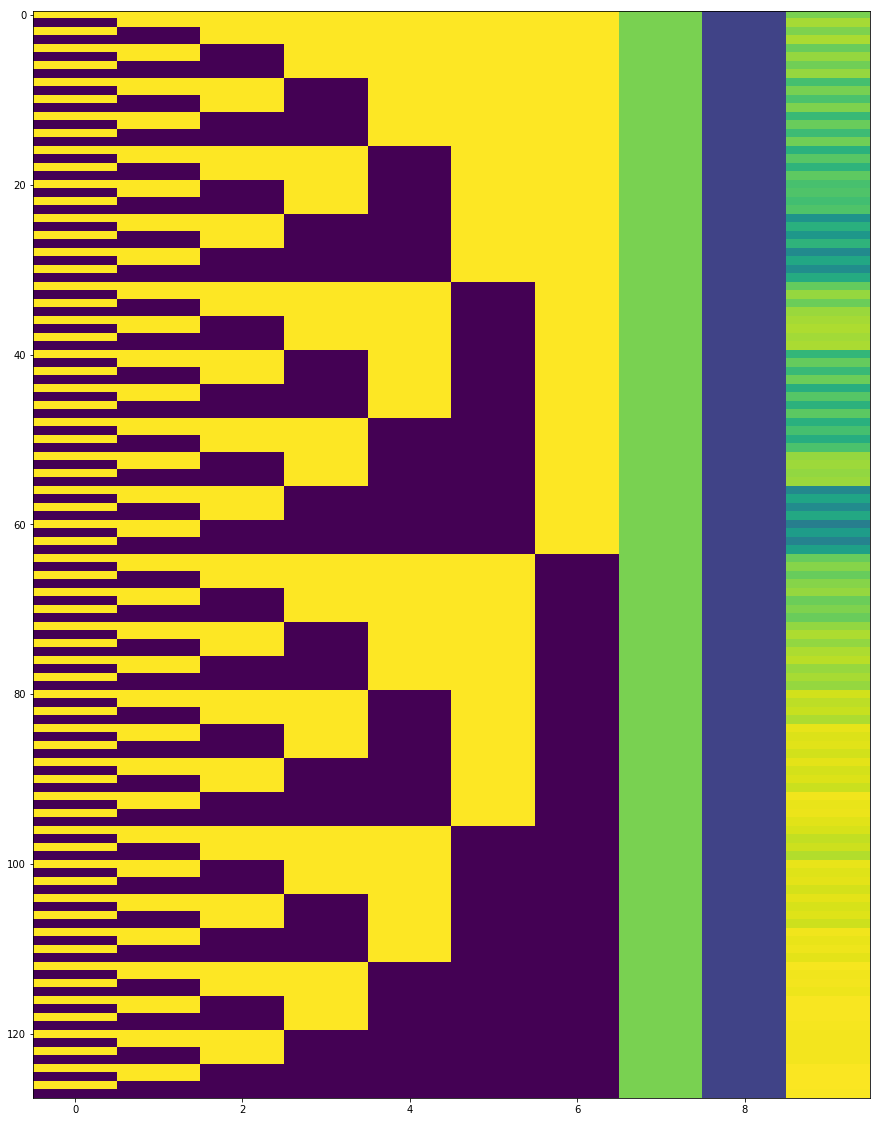

In [129]:
# For investigating weight model

import matplotlib.pyplot as plt
import itertools
import pickle
import sklearn

with open("weight_model.b10_md0.48_h7_l2_prior.quant.best.pkl", "rb") as file:
    model = pickle.load(file)["model"]

ac = 0.8
la = 0.2

lst = np.array([list(i) for i in itertools.product([0, 1], repeat=7)])[::-1,::-1]

data = np.zeros((len(lst), 10))
data[:, :7] = lst
data[:, 7] = ac
data[:, 8] = la

data[:, 9] = model.predict_proba(data[:, :9])[:, 1]

#data = data[np.where(data[:, 6] == 1)[0]]

fig, ax = plt.subplots(figsize=(15, 20))
ax.imshow(data, aspect='auto')
plt.show()

[[ 7.60147601e-01  8.70689655e-01  1.10542054e-01]
 [ 5.01587302e-01  5.19083969e-01  1.74966679e-02]
 [ 4.80000000e-01  5.77777778e-01  9.77777778e-02]
 [ 7.90123457e-01  9.08474576e-01  1.18351119e-01]
 [ 6.61710037e-01  7.96296296e-01  1.34586259e-01]
 [ 5.80858086e-01  7.25190840e-01  1.44332754e-01]
 [ 7.01902748e-01  7.41228070e-01  3.93253218e-02]
 [ 8.45188285e-01  7.43055556e-01 -1.02132729e-01]
 [ 6.18819777e-01  6.94096601e-01  7.52768244e-02]
 [ 7.65151515e-01  9.06666667e-01  1.41515152e-01]
 [ 6.98296837e-01  7.95539033e-01  9.72421965e-02]
 [ 6.62309368e-01  7.41463415e-01  7.91540464e-02]
 [ 6.72727273e-01  6.21848739e-01 -5.08785332e-02]
 [ 7.78688525e-01  8.45814978e-01  6.71264534e-02]
 [ 7.86627335e-01  7.57515030e-01 -2.91123052e-02]
 [ 6.73913043e-01  7.56097561e-01  8.21845175e-02]
 [ 8.53333333e-01  9.62962963e-01  1.09629630e-01]
 [ 8.07377049e-01  8.35497835e-01  2.81207863e-02]
 [ 8.66290019e-01  8.99224806e-01  3.29347874e-02]
 [ 8.54609929e-01  9.11877395e-

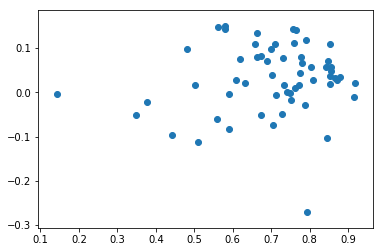

In [20]:
# For investigating score diff in relation to acoustic performance

import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

baseline_dir = "results/save/save-quant-hmm"
model_dir = "results/save/save-quant-gtweight"

try:
    results_file = "results.p"
    with open(os.path.join(baseline_dir, results_file), "rb") as file:
        baseline = pickle.load(file)
except:
    results_file = "results.pkl"
    with open(os.path.join(baseline_dir, results_file), "rb") as file:
        baseline = pickle.load(file)

try:
    results_file = "results.p"
    with open(os.path.join(model_dir, results_file), "rb") as file:
        model = pickle.load(file)
except:
    results_file = "results.pkl"
    with open(os.path.join(model_dir, results_file), "rb") as file:
        model = pickle.load(file)
    
scores = np.zeros((0, 3))
pieces = []
for piece in baseline:
    pieces.append(piece)
    scores = np.vstack((scores, [baseline[piece][1][2], model[piece][1][2],
                                 model[piece][1][2] - baseline[piece][1][2]]))
    
plt.scatter(scores[:, 0], scores[:, 2])
print(scores)